# Anomaly Detection VAE

Variational Autoencoders are powerful tools for anomaly detection. By learning a compact latent representation of the input, they are able to model the structure of normal data. This makes them well-suited for identifying inputs that deviate significantly from the learned distribution, i. e., anomalous data.

In this notebook, we will explore this idea using the MRI Brain X-Ray dataset, which contains scans of both healthy brains and brains affected by various types of cancer. The goal is to leverage the VAE's capacity to capture the distribution of healthy images and use reconstruction errors to flag potential anomalies. In other words, we will train our VAE with healthy brains and then we will use the test data reconstruction error to detect regions with anomalies.

Firstly, we import some libraries and dependencies

In [1]:
import sys 
import os 

sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from torch import optim
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from src.model import VAE
from src.configs import brain_configs
from src.train import train
from src.utils import load_brain, visualize_brain_examples, visualize_heatmap

The device used during training is CUDA. However, this dataset has a short number of samples and can be trained using the CPU (it will last longer with current batch_size).

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


The original dataset has been modified. Since we are applying an unsupervised learning method and the dataset is small, I have taken 200 of the 300 healthy brain test images for training. By doing so we there are 1900 training images, all of them from healthy brains scans.
These images will be in grayscale and will have a resolution of $256 \times 256$ pixels. We will use a batch size of 128 samples and the following transformation methods will be applied to image data:

- `transforms.Resize((image_size, image_size))`. Most images have a different but close resolution to $256 \times 256$ pixels, in order to have an homogeneous dataset we will apply this method.

- `transforms.Grayscale(num_output_channels=1)` 

- `transforms.GaussianBlur()` will apply a little of Gaussian Blur to the images. One of the main problems with scans for VAEs is the contrast between the skull cortex and the dark background of the scan. Although our model will see this edges in every single training sample, it will have some high reconstruction error in this areas. In order to mitigate this effect we add gaussianblur to the training examples.

- `transforms.ToTensor()`

-  `transforms.Normalize(mean=0.5, std=0.5)` will normalize the tensor values to the $[-1,1]$ interval. This is useful to reduce the effect of contrast previously mentioned.

In [4]:
root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Training\notumor"
brain_loader = load_brain(root)

In [5]:
for batch in brain_loader:
    print(f"{batch.shape}")
    break

torch.Size([128, 65536])


Once the training images are loaded we can visualize some examples using `visualize_brain_examples` from `src/utils.py`.

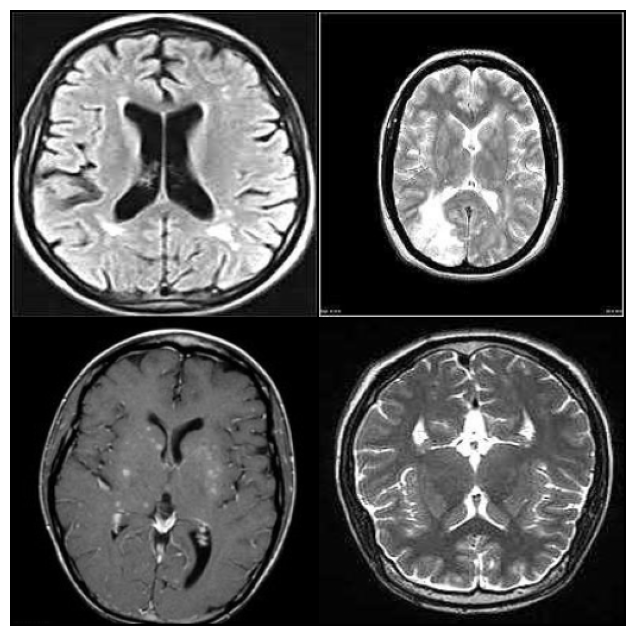

In [6]:
visualize_brain_examples(dataloader=brain_loader, num_examples=4, fig_size=(8,8))

Now, we define our model. We will use a final $\tanh$ activation function and MSE as reconstruction error because we are using $[-1,1]$ tensors for training.

After some tests, the model has performed best when setting $\alpha = 3 \cdot 10^{-4}$, 50 epochs and hidden layers dimensions 1024, 512 and 256, as well as a 64 dimension latent space.

In [7]:
model = VAE(**brain_configs, f_out = 'tanh')

In [8]:
optimizer = optim.Adam(model.parameters(), lr= 3e-4)

train(model,brain_loader,optimizer,device,epochs=50, f_out='tanh', max_beta = 1.5)

Epoch 1 -----> -ELBO: 17759.553038239916 | KL: 92418.5234375 | Reconstruction Error: 1199682.75
Epoch 2 -----> -ELBO: 9479.363672079622 | KL: 67088.84375 | Reconstruction Error: 1103370.875
Epoch 3 -----> -ELBO: 8777.82798585647 | KL: 66645.1484375 | Reconstruction Error: 969135.875
Epoch 4 -----> -ELBO: 7920.952069146149 | KL: 54948.5703125 | Reconstruction Error: 946753.0625
Epoch 5 -----> -ELBO: 7606.225379779989 | KL: 53340.48828125 | Reconstruction Error: 869113.375
Epoch 6 -----> -ELBO: 7437.981796752227 | KL: 37952.33203125 | Reconstruction Error: 868487.0
Epoch 7 -----> -ELBO: 7329.360921948664 | KL: 27049.365234375 | Reconstruction Error: 880751.375
Epoch 8 -----> -ELBO: 7226.106240178104 | KL: 27142.23046875 | Reconstruction Error: 885838.4375
Epoch 9 -----> -ELBO: 7132.715590623363 | KL: 27769.130859375 | Reconstruction Error: 786406.75
Epoch 10 -----> -ELBO: 7045.165237035097 | KL: 22635.82421875 | Reconstruction Error: 790903.375
Epoch 11 -----> -ELBO: 6919.012506547931 | 

The model training lasted 6 minutes and 35 seconds.

Now we will visualize some test data in search of anomalies. We will plot each original scan and its reoconstruction error heatmap. The model should perform poorly in anomalous regions containing tumors or other signs of cancer. Those regions will be visible in the heatmap. The function used for this visualizations can be found in `src/utils.py`.

#### Meningioma

The first image contains a type of brain cancer called meningioma. Meningioma, also known as meningeal tumor, is typically a slow-growing tumor that forms from the meninges, the membranous layers surrounding the brain and spinal cord. Many cases never produce symptoms.
In scans, meningiomas typically appear as well-defined, extra-axial masses with homogeneous contrast and fortunately are easy to identify. 

\-*Wikipedia*

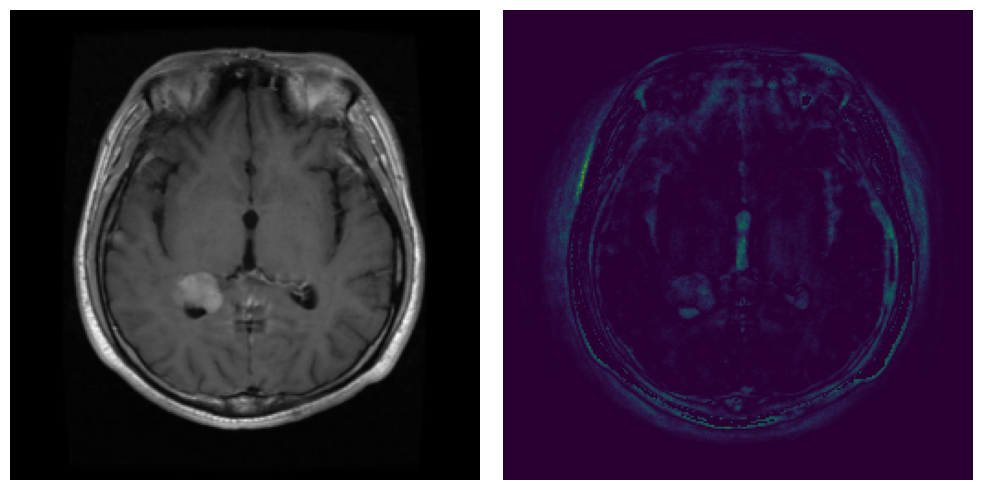

In [84]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-me_0297.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.01, cmap='viridis')

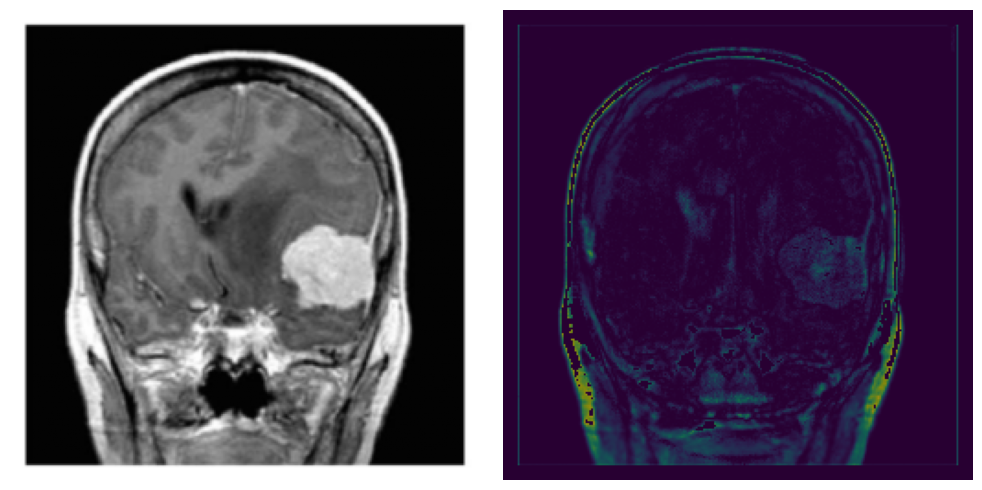

In [47]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-me_0014.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.8, cmap='viridis')

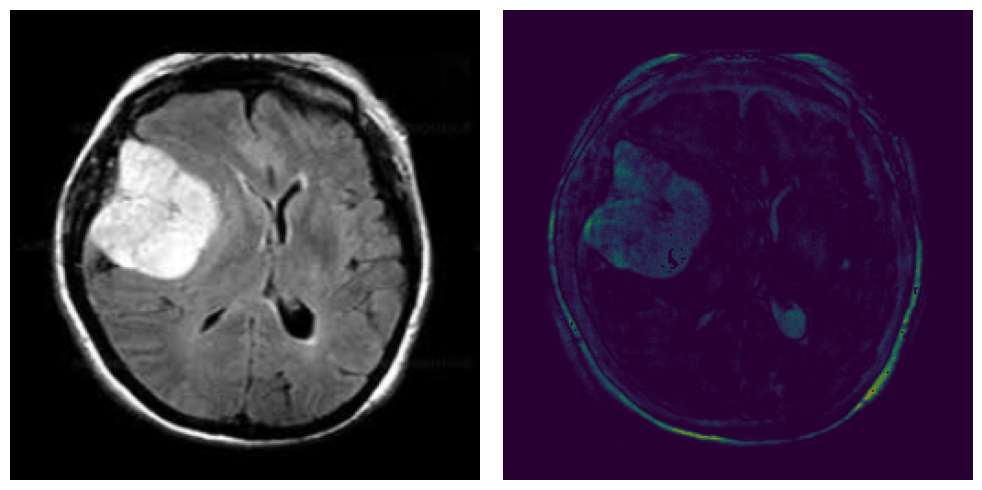

In [59]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-me_0101.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold = 1, cmap='viridis')

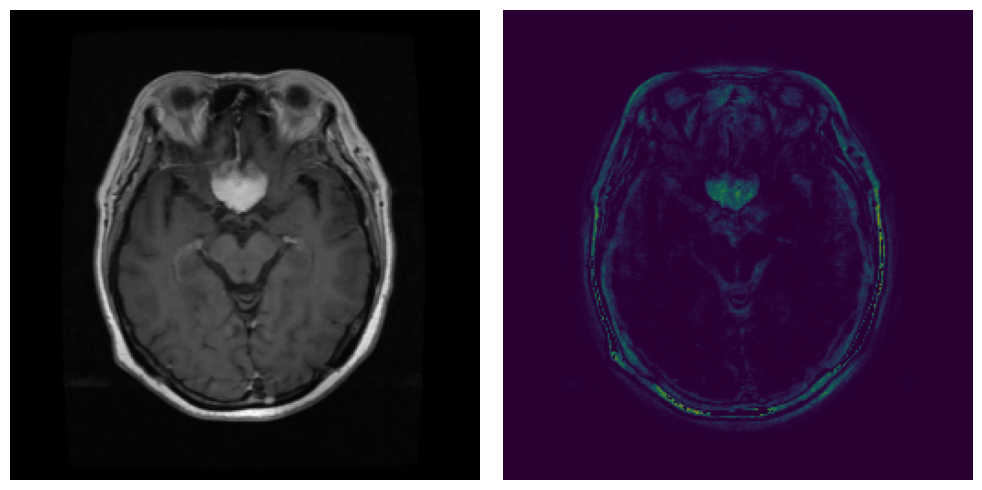

In [70]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-me_0300.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.39, cmap='viridis')

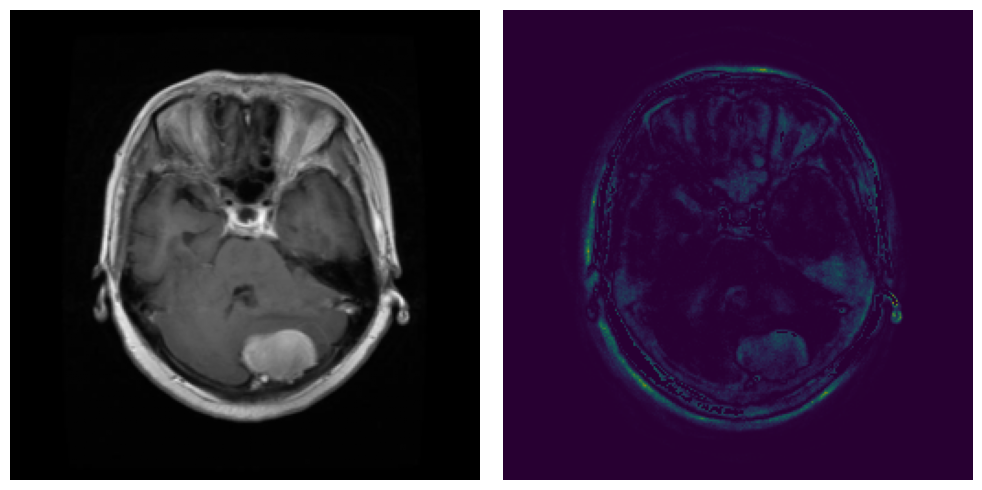

In [87]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-me_0305.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.23, cmap='viridis')

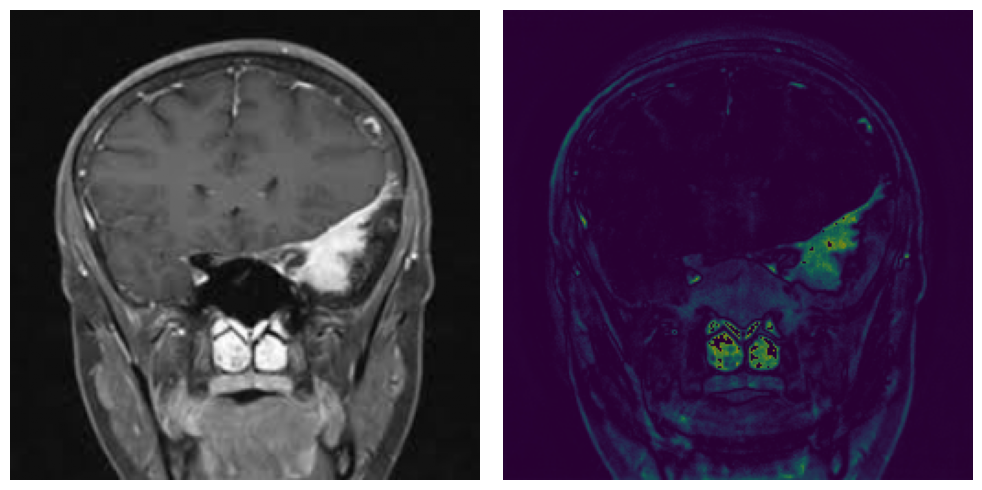

In [198]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-meTr_0003.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.91, cmap='viridis', download='meningioma.pdf')

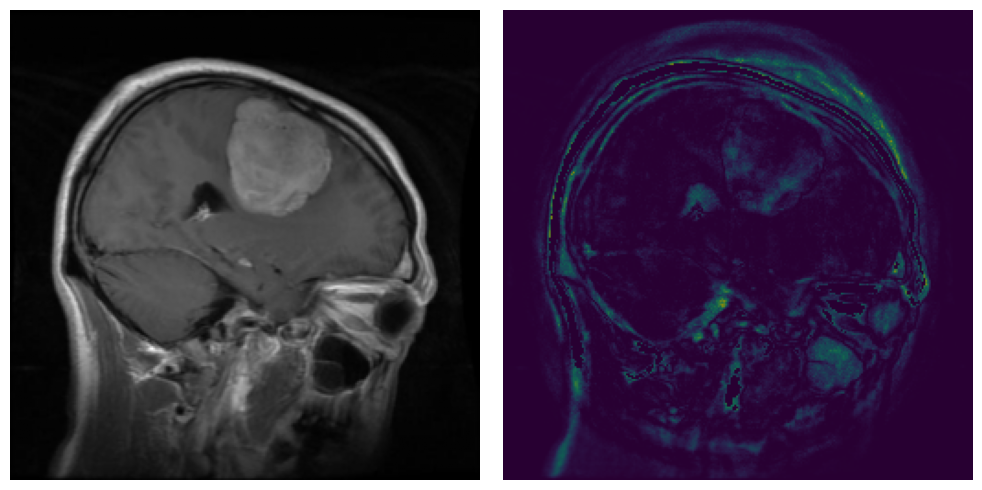

In [94]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\meningioma\Te-me_0242.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.025, cmap='viridis')

#### Glioma

A glioma is a type of primary tumor that starts in the glial cells of the brain or spinal cord. They are malignant but some are extremely slow to develop.[2][3] Gliomas comprise about 30% of all brain and central nervous system tumors and 80% of all malignant brain tumors. In scans, gliomas often appear as irregular, infiltrative masses with varying degrees of contrast enhancement. High-grade gliomas typically exhibit heterogeneous intensity, necrotic regions, and surrounding edema, making them more complex to delineate compared to well-circumscribed tumors like meningiomas.

\- *Wikipedia* 

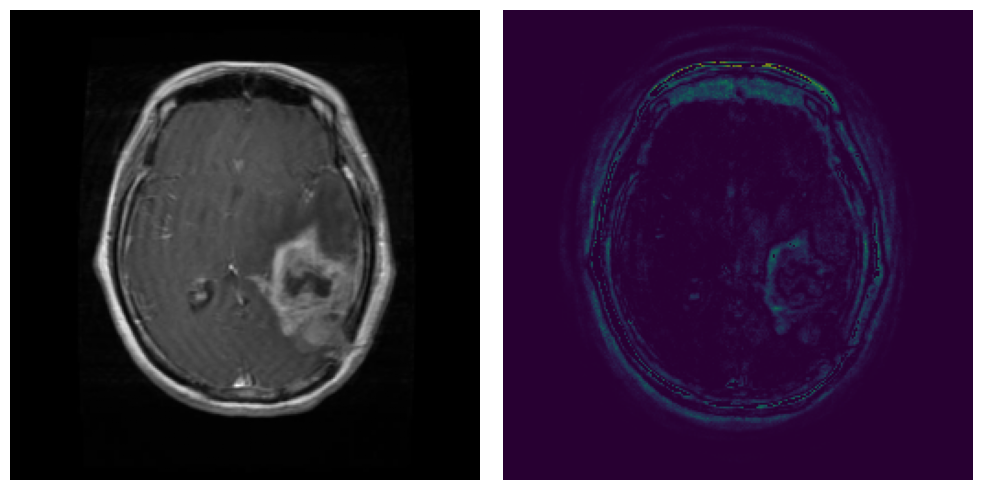

In [116]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\glioma\Te-gl_0022.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.13, cmap='viridis')

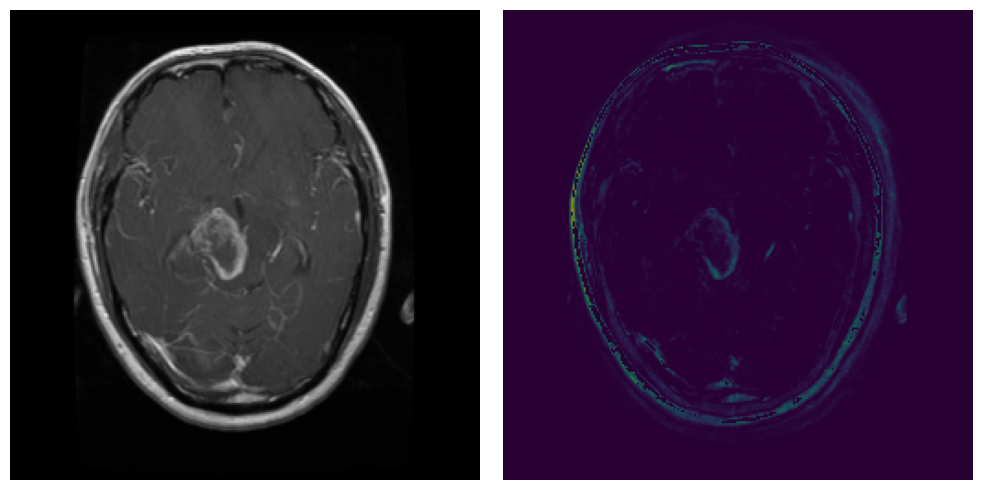

In [186]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\glioma\Te-gl_0026.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=0.14, cmap='viridis', download= 'glioma.pdf')

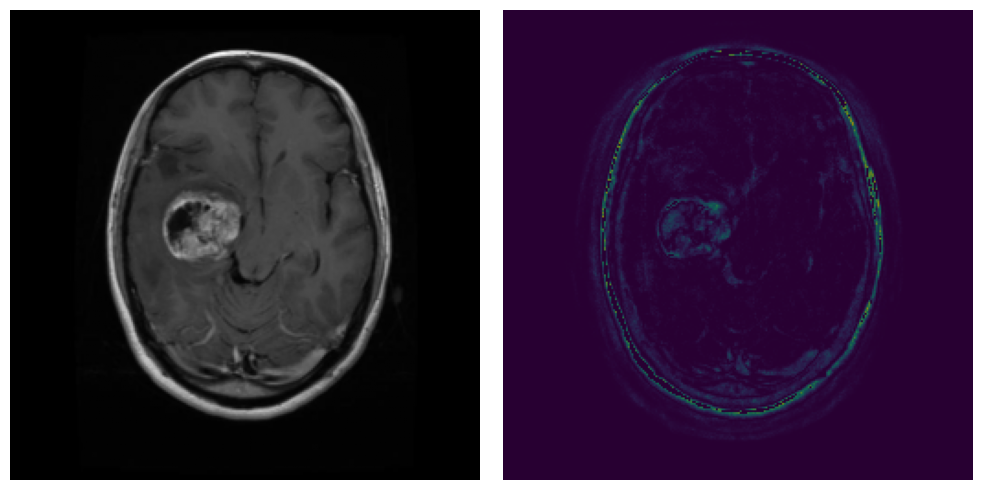

In [143]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\glioma\Te-gl_0028.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=.1, cmap='viridis')

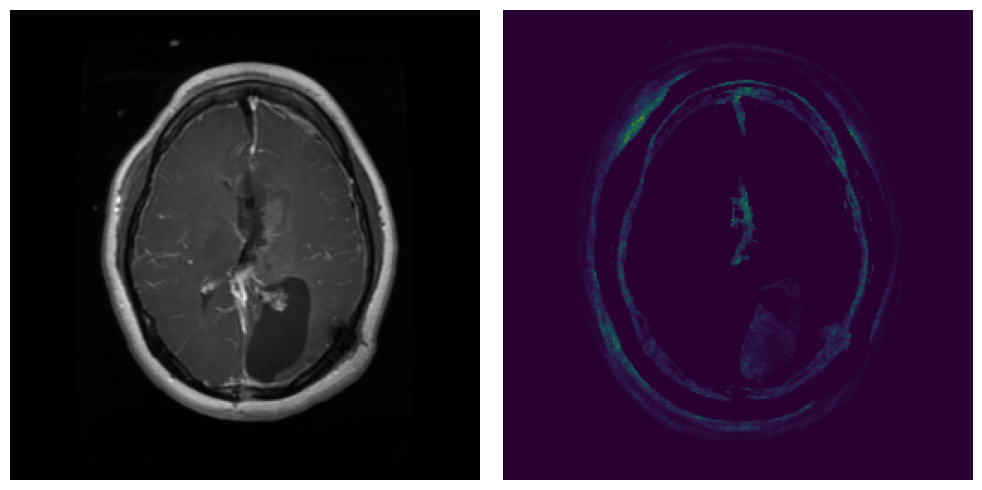

In [164]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\glioma\Te-gl_0032.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=-0.7, cmap='viridis')

#### Pituitary

Pituitary tumors are abnormal growths that develop in the pituitary gland, a small hormone-producing gland located at the base of the brain. Most pituitary tumors are benign, but their growth can disrupt hormonal balance and compress nearby structures such as the optic nerves.

\- *Wikipedia*


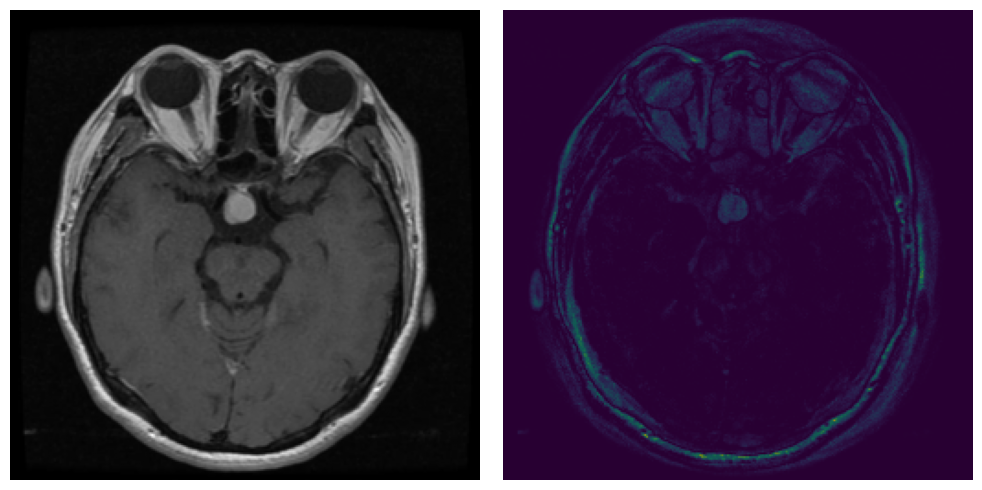

In [185]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\pituitary\Te-pi_0036.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=1, cmap='viridis', download= 'pituitary.pdf')

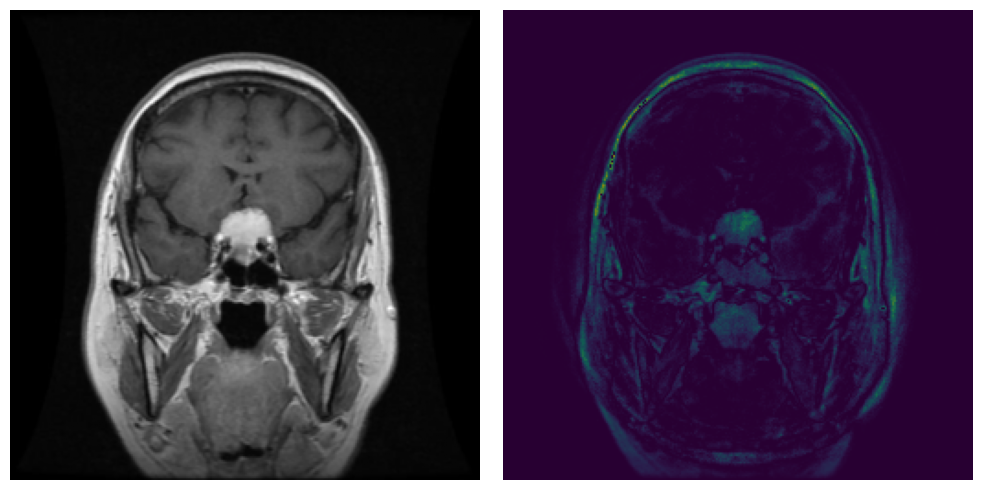

In [183]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\pituitary\Te-piTr_0002.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=.78, cmap='viridis')

#### No Tumor

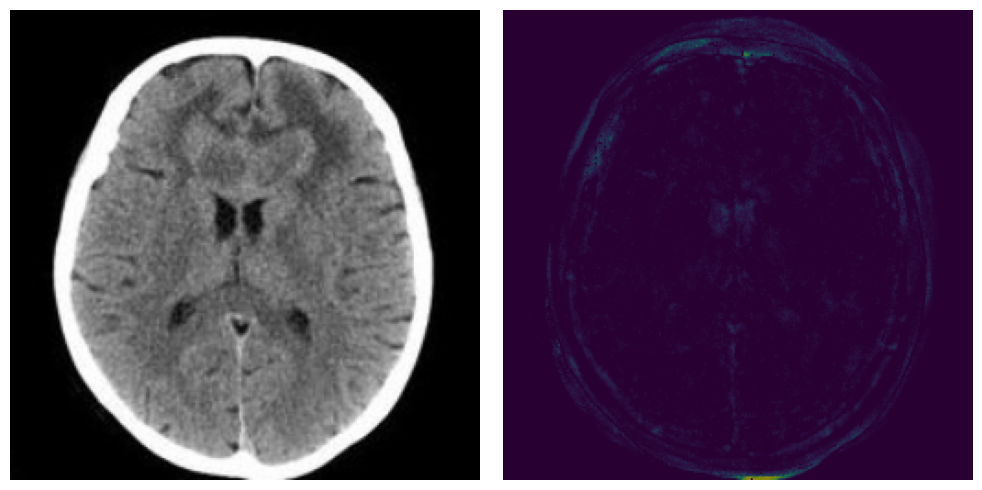

In [184]:
model.eval()

test_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\mri_brain_tumor\Testing\notumor\Te-no_0043.jpg"
image = Image.open(test_root).convert('L')

visualize_heatmap(image, model, device, threshold=1, cmap='viridis', download='notumor.pdf')